# Transformers - Trans-U-Net

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code


In [23]:
# from constants import TRANSFORMER_DIR
# import os

# TRANS_U_NET_PATH = os.path.join(TRANSFORMER_DIR, "trans_u_net")
# #EXPORT_PATH = os.path.join(TRANSFORMER_DIR, "trans_u_net", "export", "TU_ISIC_224")
# EXPORT_PATH = os.path.join(TRANSFORMER_DIR, "trans_u_net", "export", "lightning")

In [28]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_22_1755", "trans_u_net", "lightning", "lightning_logs", "version_1", "checkpoints"
)

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_22_1755/trans_u_net/lightning/lightning_logs/version_1/checkpoints


In [29]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer
from transformers.trans_u_net.my_trainer import TransUNetLightning

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 224
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "epoch=14-step=1694.ckpt")
azure_model.load_state_dict(torch.load(snapshot))

TransUNetLightning(
  (model): VisionTransformer(
    (transformer): Transformer(
      (embeddings): Embeddings(
        (hybrid_model): ResNetV2(
          (root): Sequential(
            (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (gn): GroupNorm(32, 64, eps=1e-06, affine=True)
            (relu): ReLU(inplace=True)
          )
          (body): Sequential(
            (block1): Sequential(
              (unit1): PreActBottleneck(
                (gn1): GroupNorm(32, 64, eps=1e-06, affine=True)
                (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (gn2): GroupNorm(32, 64, eps=1e-06, affine=True)
                (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (gn3): GroupNorm(32, 256, eps=1e-06, affine=True)
                (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (relu):

In [31]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(224, 224), size=5)

In [32]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 224, 224])
<class 'torch.Tensor'>


(1, 224, 224, 3)


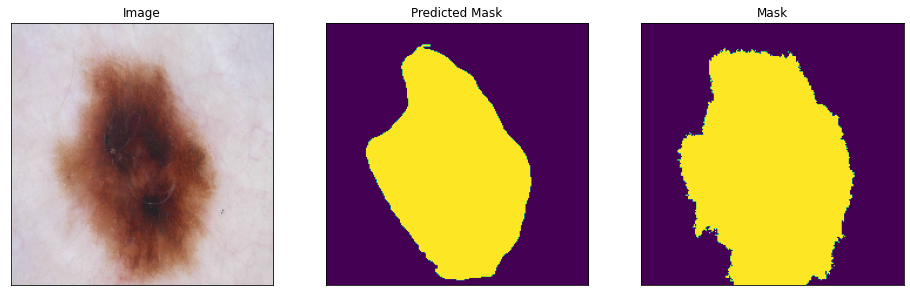

In [33]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [34]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(224, 224))
len(test_images)

300

In [35]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 224, 224, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 10min 40s, sys: 1min 3s, total: 11min 43s
Wall time: 4min 56s


In [36]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 45 s, sys: 389 ms, total: 45.4 s
Wall time: 45.7 s


{'n_images': 300,
 'n_true_positives': 2503662,
 'n_true_positives_%': 0.7193457437226168,
 'n_true_negatives': 10839565,
 'n_true_negatives_%': 0.9366796433112125,
 'n_false_positives': 732764,
 'n_false_negatives': 976809,
 'iou_score': 0.5720572835241001,
 'threshold_jaccard_index': 0.3698800292132045,
 'jaccard_similarity_index': 0.5720572835241001,
 'dice': 0.6901222053056545,
 'f1_score': 0.34506110265282725,
 'sensitivity': 0.8750904848630656,
 'specificity': 0.9464249991016114,
 'accuracy': 0.8864282392644558}